# Algorithms

These are the algorithms verbatim from the paper. They are faithful to the paper, rather than being best Python code.


In [52]:
# Algorithm 1

def combine_uniform(U_n, n, U_m, m):
    U_nm = U_n * m + U_m
    nm = n*m
    return U_nm, nm

In [53]:
# Algorithm 2

def divide_uniform(U_nm, nm, m):
    U_n = U_nm // m
    U_m = U_nm % m
    n = nm // m
    return U_n, n, U_m

In [54]:
# Algorithm 3

def sample_uniform(U_n, n, m):
    if U_n < m:
        B = 1
        x = m
        U_x = U_n
    else:
        B = 0
        x = n-m
        U_x = U_n - m
    return U_x, x, B

In [55]:
def expand(U_x, B, m):
    if B==1:
        U_n = U_x
    else:
        U_n = m + U_x
    return U_n

In [56]:
import random

def fetch():
    return random.randint(0,1)

def fetch_bit(U_s, s):
    U_s, s = combine(U_s, s, fetch(), 2)
    return U_s, s

N = 1<<31

In [57]:
# Algorithm 4

def make_generate_multiple(fetch = fetch_bit, N = 1<<31):

    def generate_multiple(U_s, s, n):
        assert n <= N
        while True:
            while s < N:
                U_s, s = fetch(U_s, s)
            k, r = divmod(s, n)
            assert n <= s
            assert U_s < s
            U_s, s, B = sample_uniform(U_s, s, s - r)
            if B==1:
                return U_s, s, k

    return generate_multiple


In [58]:
# Algorithm 5

def generate_uniform(U_s, s, generate_multiple, n):
    U_s, s, m = generate_multiple(U_s, s, n)
    assert s == m * n
    U_s, s, U_n = divide(U_s, s, n)
    return U_s, s, U_n


In [59]:
# Algorithm 6

def generate_bernoulli(U_s, s, generate_multiple, m, n):
    U_s, s, k = generate_multiple(U_s, s, n)
    U_s, s, B = sample(U_s, s, m*k)
    return U_s, s, B

In [60]:

def make_weighted(weights):
    outputs = []
    offsets = []
    for i, w_i in enumerate(weights):
        offsets = offsets + [len(outputs)]
        outputs = outputs + [i]*w_i
    return outputs, offsets

In [61]:
# Algorithm 9

def generate_weighted(U_s, s, generate_multiple, weights, outputs, offsets):
    U_s, s, k = generate_multiple(U_s, s, len(outputs))
    I = U_s // k
    W = outputs[I]
    U_s = U_s - offsets[W]*k
    s = k * weights[W]
    return U_s, s, W

In [62]:
def combine_uniformXX(U_s, s, U_n, n):
    U_s = U_s * s + U_n
    s = s * n
    return U_s, s

In [63]:
# Delete this it does not work

def combine_bernoulli(U_s, s, generate_multiple, m, n, B):
    if B==1:
        U_s, s, k = generate_multiple(U_s, s, m)
    else:
        U_s, s, k = generate_multiple(U_s, s, n-m)
        U_s = U_s + k * m
    s = k * n
    return U_s, s

# Debug variations:

def combine_bernoulli(U_s, s, generate_multiple, m, n, B):
    assert U_s < s
    assert m <= n
    assert B==0 or B==1
    if B==1:
        #assert s >= m
        U_s, s, k = generate_multiple(U_s, s, m)
        assert k > 0
        assert s == k*m
        assert U_s < s
    else:
        #assert s >= m
        assert n > m
        U_s, s, k = generate_multiple(U_s, s, n-m)
        assert s>0
        assert U_s < s
        assert s == k * (n-m)
        U_s = U_s + k * m
        assert k > 0
    s = k * n
    return U_s, s    

def combine_bernoulliXXX(U_s, s, generate_multiple, m, n, B):
    assert U_s < s
    assert m <= n
    assert B==0 or B==1
    if B==1:
        #assert s >= m
        U_x, x, k = generate_multiple(U_s, s, m)
    else:
        U_x, x, k = generate_multiple(U_s, s, n-m)
    U_s, s = expand(U_x, B, k*m), k*n
    return U_s, s

In [64]:
# Algorithm 11

def combine_weighted(U_s, s, generate_multiple, weights, outputs, offsets, W):
    U_s, s, k = generate_multiple(U_s, s, weights[W])
    U_s += offsets[W] * k
    s = s * len(outputs)
    return U_s, s

# Graphs

Here are the functions used to calculate the graphs:


In [65]:
import math

class VonNeumannAlgorithm:
    def uniform_entropy(self, n):
        r = 1 # The smallest power of 2 >= than range 
        b = 0 # The number of bits in r
        while r < n:
            r *= 2
            b += 1
        return r*b/n

    def uniform_loss(self, n):
        return self.uniform_entropy(n) - math.log2(n)

class KnuthYaoAlgorithm:
    def uniform_entropy(self, n):
        def calculate_fdr_exact(u, depth):
            count = 0
            while u<n:
                u *= 2
                count += 1
            if n==u or depth==1:
                return count
            p = n/u
            return count + (1-p) * calculate_fdr_exact(u-n, depth-1)

        return calculate_fdr_exact(1, 8)

    def uniform_loss(self, n):
        return self.uniform_entropy(n) - math.log2(n)

class LemireAlgorithm:
    def uniform_entropy(self, n):
        # Not quite true !!
        return 128

    def uniform_loss(self, n):
        return self.uniform_entropy(n) - math.log2(n)

def epsilon(n, N):
    if n==1:
        return 0
    p = (n-1)/N
    return -(p/(1-p))*math.log2(p) - math.log2(1-p)

def binary_entropy(p):
    if p==0:
        return 0
    return -p*math.log2(p) - (1-p)*math.log2(1-p)

class WorstCaseES:
    def __init__(self, bits):
        self.N = 1<<(bits-1)

    def uniform_loss(self, n):
        return epsilon(n, self.N)

    def uniform_entropy(self, n):
        return math.log2(n) + self.uniform_loss(n)

    def bernoulli_entropy(self, p):
        return binary_entropy(p) + self.uniform_loss(1/p)

class RealWorldES:
    def __init__(self, bits):
        self.N = 1<<(bits-1)
        self.s = 1

    def uniform_loss(self, n):
        while self.s<self.N:
            self.s = self.s * 2
        p = (self.s%n)/self.s
        self.s = self.s/n
        return binary_entropy(p)

    def uniform_entropy(self, n):
        return self.uniform_loss(n) + math.log2(n)

    def bernoulli_entropy(self, p):
        return binary_entropy(p) + self.uniform_loss(1/p)


def card_shuffling_loss(algorithm):
    def loss(size):
        total = 0
        for i in range(1,size+1):
            total += algorithm.uniform_loss(i)
        return total
    return loss

def card_shuffling_efficiency(algorithm):
    def efficiency(n):
        output = 0
        input = 0
        for i in range(1,n+1):
            output += math.log2(i)
            input += algorithm.uniform_entropy(i)
        return output / input
    return efficiency

class IntervalAlgorithm:
    def bernoulli_entropy(self, p):
        def simulate(depth, range, delta):
            if range>=p or depth>10 or range+delta<=p:
                return depth * delta
            delta *= 0.5
            depth += 1
            return simulate(depth, range, delta) + simulate(depth, range+delta, delta)
        return simulate(0, 0, 1)

def bernoulli_efficiency(algorithm):
    def efficiency(m, n):
        p = m/n
        output = binary_entropy(p)
        return output/algorithm.bernoulli_entropy(p)
    return efficiency

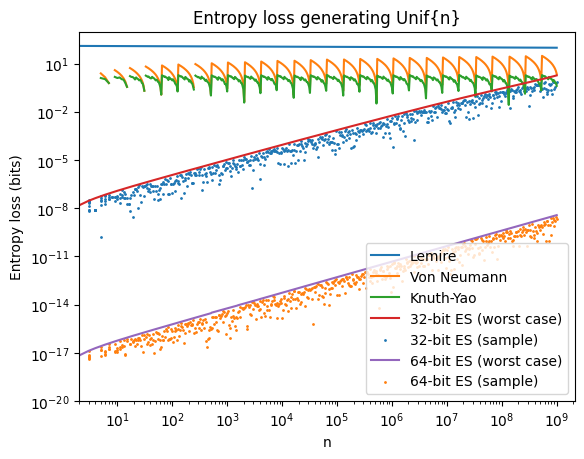

In [66]:
import numpy as np
import matplotlib.pyplot as plt

vn = VonNeumannAlgorithm()
ky = KnuthYaoAlgorithm()
es32_worst = WorstCaseES(32)
es32_real = RealWorldES(32)
es64_worst = WorstCaseES(64)
es64_real = RealWorldES(64)
lemire = LemireAlgorithm()

def filter0(x):
    '''Don't show zeros on the graph'''
    return x if x>0 else math.nan

series = [math.floor(f) for f in np.logspace(0, 9, 640)]
epsilon32_losses = [es32_worst.uniform_loss(n) for n in series]
epsilon32_actuals = [es32_real.uniform_loss(n) for n in series]
epsilon64_losses = [es64_worst.uniform_loss(n) for n in series]
epsilon64_actuals = [es64_real.uniform_loss(n) for n in series]
vn_losses = [filter0(vn.uniform_loss(n)) for n in series]
ky_losses = [filter0(ky.uniform_loss(n)) for n in series]
lemire_losses = [filter0(lemire.uniform_loss(n)) for n in series]

plt.clf()

plt.title('Entropy loss generating Unif{n}')

plt.xlabel('n')
plt.ylabel('Entropy loss (bits)')

plt.yscale('log')
plt.ylim(1e-20, 1e3)
plt.xlim(2, 2**31)
plt.xscale('log')

# plt.grid(True, which="both", ls="--")
plt.plot(series, lemire_losses, label='Lemire')
plt.plot(series, vn_losses, label='Von Neumann')
plt.plot(series, ky_losses, label='Knuth-Yao')
plt.plot(series, epsilon32_losses, label='32-bit ES (worst case)')
plt.scatter(series, epsilon32_actuals, label='32-bit ES (sample)', s=1)
plt.plot(series, epsilon64_losses, label='64-bit ES (worst case)')
plt.scatter(series, epsilon64_actuals, label='64-bit ES (sample)', s=1)
plt.legend(loc='lower right')
plt.savefig('uniform_losses.png', dpi=600)
plt.show()

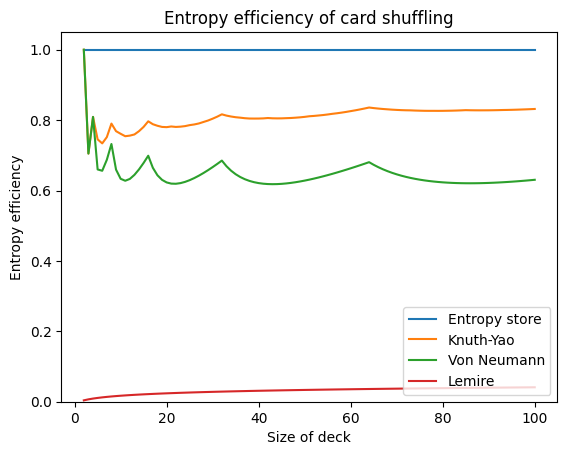

In [67]:
vn_efficiency_fn = card_shuffling_efficiency(vn)
ky_efficiency_fn = card_shuffling_efficiency(ky)
es32_efficiency_fn = card_shuffling_efficiency(es32_worst)
lemire_efficiency_fn = card_shuffling_efficiency(lemire)

numbers = range(2,101)

vn_efficiency = [vn_efficiency_fn(n) for n in numbers]
ky_efficiency = [ky_efficiency_fn(n) for n in numbers]
es_efficiency = [es32_efficiency_fn(n) for n in numbers]
lemire_efficiency = [lemire_efficiency_fn(n) for n in numbers]

plt.clf()
plt.title('Entropy efficiency of card shuffling')

plt.xlabel('Size of deck')
plt.ylabel('Entropy efficiency')
plt.ylim(0,1.05)
plt.plot(numbers, es_efficiency, label='Entropy store')
plt.plot(numbers, ky_efficiency, label='Knuth-Yao')
plt.plot(numbers, vn_efficiency, label='Von Neumann')
plt.plot(numbers, lemire_efficiency, label='Lemire')
plt.legend(loc='lower right')
plt.savefig('shuffling_efficiency.png', dpi=600)
plt.show()

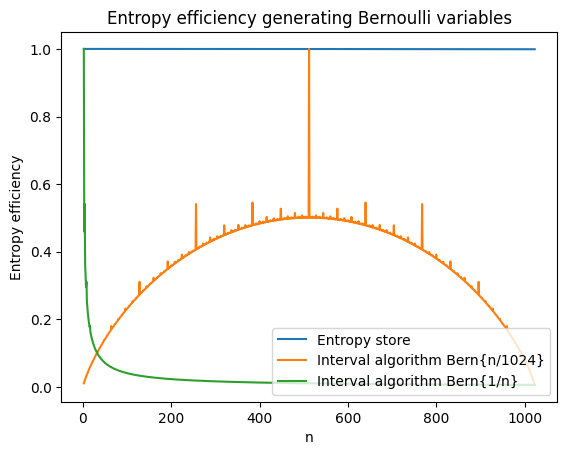

In [68]:
series = range(2,1024)
ia = IntervalAlgorithm()
interval_efficiency = [bernoulli_efficiency(ia)(1,n) for n in series]
interval_efficiency2 = [bernoulli_efficiency(ia)(n,1024) for n in series]
es_efficiency = [bernoulli_efficiency(es32_worst)(1,n) for n in series]
es_efficiency2 = [bernoulli_efficiency(es32_worst)(n,1024) for n in series]

plt.clf()

plt.title('Entropy efficiency generating Bernoulli variables')

plt.xlabel('n')
plt.ylabel('Entropy efficiency')

# plt.grid(True, which="both", ls="--")
plt.plot(series, es_efficiency, label='Entropy store')
plt.plot(series, interval_efficiency2, label='Interval algorithm Bern{n/1024}')
plt.plot(series, interval_efficiency, label='Interval algorithm Bern{1/n}')
plt.legend(loc='lower right')
plt.savefig('bernoulli_efficiency.png', dpi=600)
plt.show()

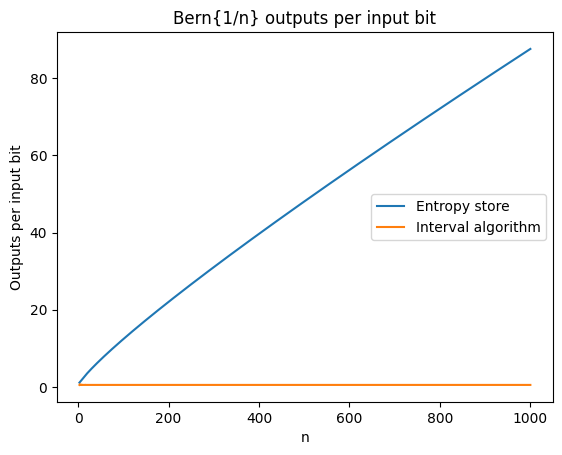

In [69]:
series = range(3,1001)
es_output_rate = [1/es32_worst.bernoulli_entropy(1/n) for n in series]
ia_output_rate = [1/ia.bernoulli_entropy(1/n) for n in series]

plt.clf()

plt.title('Bern{1/n} outputs per input bit')

plt.xlabel('n')
plt.ylabel('Outputs per input bit')

# plt.grid(True, which="both", ls="--")
plt.plot(series, es_output_rate, label='Entropy store')
plt.plot(series, ia_output_rate, label='Interval algorithm')
plt.legend(loc='center right')
plt.savefig('bernoulli_rate.png', dpi=600)
plt.show()

# Correctness

We will primarily test the correctness of the implementation: are the outputs correctly distributed? We can test the number of outputs, and also the number of sequential pairs. For each count we can calculate its distance from the mean in terms of number of standard deviations, and check that we are within $4\sigma$.

$$\sigma \approxeq \sqrt{np(1-p)}$$

In [70]:
import numpy as np
import pandas as pd
import itertools
import traceback

class EntropyStore:
    def __init__(self, bits, gen = None, trace = False):
        self.U_s = 0
        self.s = 1
        self.trace = trace
        if gen is None:
            self.generate_multiple = make_generate_multiple(fetch_bit, 1<<bits)
        else:
            self.generate_multiple = gen
        if trace:
            self.old_gm = self.generate_multiple
            self.generate_multiple = lambda U_s, s, n: self.log_generate_multiple(U_s, s, n)

    def log_generate_multiple(self, U_s, s, n):
        if self.trace:
            print(f"About to call generate_multiple ({U_s}, {s}, {n})")
        U_s2, s2, k = self.old_gm(U_s, s, n)
        if self.trace:
            print(f"Called generate_multiple ({U_s}, {s}, {n}) -> ({U_s2}, {s2}, {k})")
        return U_s2, s2, k

    def generate_uniform(self, n):
        self.U_s, self.s, U_n = generate_uniform(self.U_s, self.s, self.generate_multiple, n)
        return U_n

    def generate_bernoulli(self, m, n):
        old_U_s= self.U_s
        old_s = self.s
        self.U_s, self.s, B = generate_bernoulli(self.U_s, self.s, self.generate_multiple, m, n)
        if self.trace:
            print(f"Called generate_bernoulli({old_U_s}, {old_s}, {m}/{n}) -> ({self.U_s}, {self.s}, {B})")
        return B

    def generate_weighted(self, weights, outputs, offsets):
        self.U_s, self.s, i = generate_weighted(self.U_s, self.s, self.generate_multiple, weights, outputs, offsets);
        return i

    def __repr__(self):
        return f"EntropyStore(U_s={self.U_s},s={self.s})"

class UniformDistribution:
    def __init__(self, min, max):
        self.min = min
        self.max = max

    def range(self):
        return self.max-self.min+1

    def entropy(self):
        return math.log2(self.range())

    def generate(self, es):
        return self.min + es.generate_uniform(self.range())

    def value_p(self, value):
        return 1/self.range()

    def values(self):
        return [x for x in range(self.min, self.max+1)]

    def combine(self, U_s, s, value, generate_multiple):
        return combine(U_s, s, value-self.min, self.range())

class BernoulliDistribution:
    def __init__(self, m, n):
        self.m = m
        self.n = n
        self.p = m/n

    def entropy(self):
        return binary_entropy(self.p)

    def values(self):
        return [0,1]

    def value_p(self, value):
        return self.p if value else (1-self.p)

    def generate(self, es):
        return es.generate_bernoulli(self.m, self.n)

    def combine(self, U_s, s, value, generate_multiple):
        return combine_bernoulli(U_s, s, generate_multiple, self.m, self.n, value)

class WeightedDistribution:
    def __init__(self, weights):
        self.weights = weights
        self.outputs, self.offsets = make_weighted(weights)
    
    def values(self):
        return range(0, len(self.weights))

    def entropy(self):
        e = 0
        for v in self.values():
            p = self.value_p(v)
            if p>0:
                e += -p * math.log2(p)
        return e

    def value_p(self, value):
        return self.weights[value]/len(self.outputs)

    def generate(self, es):
        return es.generate_weighted(self.weights, self.outputs, self.offsets)

    def combine(self, U_s, s, value, generate_multiple):
        return combine_weighted(U_s, s, generate_multiple, self.weights, self.outputs, self.offsets, value)

class TestDistribution:
    def __init__(self, es, distribution, count):
        self.counts = {}
        self.pairs = {}
        for v in distribution.values():
            self.counts[v] = 0
            for w in distribution.values():
                self.pairs[(v,w)] = 0
        for i in range(0,count):
            j = distribution.generate(es)
            self.counts[j] += 1
            if i>0:
                self.pairs[(prev,j)] += 1
            else:
                init = j
            prev = j
        self.pairs[(prev,init)] += 1

        self.sds = {}
        self.mean = {}
        self.sd_pairs = {}
        for i,c in self.counts.items():
            p = distribution.value_p(i)
            sd = math.sqrt(count * p * (1-p))
            delta = (c - p*count)/sd
            self.sds[i] = delta
            self.mean[i] = p*count
        for (i,j), c in self.pairs.items():
            p = distribution.value_p(i) * distribution.value_p(j)
            sd = math.sqrt(count * p * (1-p))
            delta = (c - p*count)/sd
            self.sd_pairs[(i,j)] = delta

        if self.max_sd()>=4:
            print("*** FAILED ***")
            print("sigma =", self.max_sd())

        # assert self.max_sd() < 4

    def max_sd(self):
        m = 0
        for sd in itertools.chain(self.sds.values(), self.sd_pairs.values()):
            m = max(m, math.fabs(sd))
        return m

    def display_pairs(self):
        df_display = pd.Series(self.pairs).unstack()
        df_color = pd.Series(self.sd_pairs).unstack()
        styled = df_display.style.background_gradient(cmap='bwr', vmin=-10, vmax=10, gmap=df_color, axis=None)
        return styled    

    def display_table(self):
        df_display = pd.DataFrame([self.counts]) # .from_dict(self.sds, orient='index')
        df_color = pd.DataFrame([self.sds]) # .from_dict(self.sds, orient='index')
        styled = df_display.style.background_gradient(cmap='bwr', vmin=-10, vmax=10, gmap=df_color, axis=None)
        return styled    

In [71]:
es = EntropyStore(32)
d6 = UniformDistribution(1,6)
coin = BernoulliDistribution(1,3)
w = WeightedDistribution([1,2,3])
d10 = UniformDistribution(1,10)

The following is a heatmap showing how many of each output were generated. The cell shows the number, and the colour indicates its standard deviation from the expected number.

In [72]:
TestDistribution(es, w, 1000).display_table()

NameError: name 'combine' is not defined

The following shows a heatmap of consecutive pairs of outputs. The number shown is the number of pairs, and the colour represents the standard deviation from the expected number. Some variation is expected, but the program alerts if the standard deviation is over 4 (which is possible but very unlikely). If that is the case, re-run the program to check if it's systematic or a fluke.

In [ ]:
TestDistribution(es, w, 1000).display_pairs()

,0,1,2
0,21,57,72
1,41,124,182
2,88,166,249


In [ ]:
TestDistribution(es, d6, 1000).display_pairs()

,1,2,3,4,5,6
1,27,22,25,29,26,39
2,25,27,25,21,20,30
3,30,16,22,26,33,30
4,25,28,31,34,30,26
5,25,26,28,31,26,30
6,36,29,26,33,31,32


In [ ]:
TestDistribution(es, BernoulliDistribution(4,5), 1000).display_table()

,0,1
0,180,820


In [ ]:
TestDistribution(es, BernoulliDistribution(1,1000), 1000).display_table()

,0,1
0,1000,0


# Extracting entropy

This section experiments with extracting entropy from weighted or Bernoulli variables. Unfortunately, the conclusion is that this is unsound because the size of the store depends on the values read, and so the entropy store is not in fact uniformly distributed. If we read a low-entropy input, then we need to fetch more of them to meet our minimum store size, and this leads to bias. What a shame!

This function creates an entropy store with a different `fetch()` function that actually reads from an arbitrary distribution.

In [ ]:
def make_sourced_entropy_store(source_es, source_distribution, bits=32, trace=False):
    distribution_bits = 1+int(source_distribution.entropy())

    def bootstrap_fetch(U_s, s):
        return combine(U_s, s, source_es.generate_uniform(2), 2)

    bootstrap_generate_multiple = make_generate_multiple(bootstrap_fetch, 1<<(bits - 2*distribution_bits))

    def fetch_bits(U_s, s):
        i = source_distribution.generate(source_es)
        U_s, s = source_distribution.combine(U_s, s, i, bootstrap_generate_multiple)
        return U_s, s
    return EntropyStore(bits, make_generate_multiple(fetch_bits, 1<<(bits-distribution_bits)), trace)


In [ ]:
ss = make_sourced_entropy_store(es, BernoulliDistribution(1,3))
gm = make_generate_multiple()
ss.generate_bernoulli(1,2)


0

In [ ]:
def test_conversion(es, input_distribution, output_distribution, n=1000, trace=False):
    return TestDistribution(make_sourced_entropy_store(es, input_distribution, trace=trace), output_distribution, n)

In [ ]:
test_conversion(es, d6, d6).display_pairs()

,1,2,3,4,5,6
1,32,31,27,19,27,42
2,26,24,26,25,33,25
3,24,17,28,27,28,31
4,31,28,27,28,26,27
5,31,30,32,37,21,22
6,34,29,15,31,38,21


In [ ]:
test_conversion(es, coin, coin, 100000).display_pairs()

*** FAILED ***
sigma = 4.241226473556964


,0,1
0,43778,22478
1,22478,11266


In [ ]:
test_conversion(es, BernoulliDistribution(1,2), BernoulliDistribution(1,100), 1000).display_table()

,0,1
0,984,16


In [ ]:
TestDistribution(es, BernoulliDistribution(1,5), 1000).display_table()

,0,1
0,815,185


The following fails because when we extract a Bernoulli variable we end up with two different size of store. Whilst each store size is individually uniform, it creates a bias which then fails statistical tests. The reason is that if $B(1/3)=1$, then we end up with a larger store, which biasses the values in favour of those uniform values. Conclusion, we can't extract entropy in this way.

In [ ]:
test_conversion(EntropyStore(32, trace=False), BernoulliDistribution(1,3), BernoulliDistribution(1,2), 1000, trace=False).display_table()

*** FAILED ***
sigma = 7.449026782070259


,0,1
0,418,582


In [ ]:
TestDistribution(es, BernoulliDistribution(99,100), 1000).display_table()

,0,1
0,8,992


In [ ]:
test_conversion(es, d10, w).display_pairs()

,0,1,2
0,26,63,78
1,43,106,157
2,98,137,292


In [ ]:
test_conversion(es, w, d6).display_table()

,1,2,3,4,5,6
0,171,157,140,177,172,183


In [ ]:
test_conversion(es, WeightedDistribution([3,0,2]), WeightedDistribution([4,4])).display_table()

*** FAILED ***
sigma = 23.223436438219043


,0,1
0,765,235


In [ ]:
test_conversion(es, WeightedDistribution([3,0,2]), UniformDistribution(0,1)).display_table()

,0,1
0,495,505
